In [32]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rng
from scipy.special import expit as sigmoid

def load_mnist_digit(digit, dataset_size):
    assert(digit >= 0 and digit < 10)
    with open("datasets/{}.npy".format(digit),'rb') as f:
        return np.load(f)[:dataset_size]
    
def flatten_dataset(images):
    smushed = images.copy()
    return smushed.reshape((smushed.shape[0], -1))

dataset_size = 100  # that's how many of EACH digit there is. Can go as high as... what, 5000?
vis_train_pats = flatten_dataset(load_mnist_digit(1,dataset_size))
for i in [2,3]:
    vis_train_pats = np.vstack((vis_train_pats, flatten_dataset(load_mnist_digit(i,dataset_size))))

In [18]:
print (vis_train_pats.shape)
num_pats = vis_train_pats.shape[0]
num_visibles = vis_train_pats.shape[1]

(300, 784)


## Show some examples....

(300, 784)


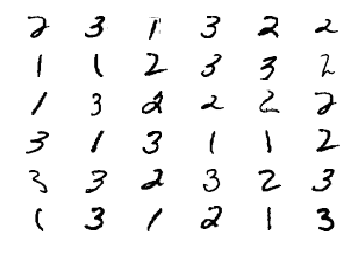

In [19]:
print(vis_train_pats.shape)
i=0
for r in range(6):
    for c in range(6):
        plt.subplot(6,6,i+1)
        plt.imshow(vis_train_pats[rng.randint(num_pats)].reshape(28,28), cmap='Greys', interpolation='nearest')
        plt.axis('off')
        i += 1

### Start from random initial weights and bias weights

In [20]:
num_hiddens = 100
hid = np.zeros(shape=(num_pats, num_hiddens), dtype=int)
W = rng.normal(0,1,size=(num_hiddens, num_visibles))
hid_bias = rng.normal(size=(1, num_hiddens))
vis_bias = rng.normal(size=(1, num_visibles))
W_change = 0
hid_bias_change = 0
vis_bias_change = 0

### Do some learning, using CD1 (contrastive divergence)

In [21]:
num_iterations = 100
announce_every = num_iterations / 10
learning_rate, momentum = 0.005, 0.95
import time
start = time.time()
for t in range(num_iterations):
    # push visible pats into hidden 
    hid_prob1 = sigmoid(np.dot(vis_train_pats, W.T) + hid_bias)
    hid_first = 1*(hid_prob1 > rng.random(size=hid_prob1.shape))
    
    # push hidden pats into visible 
    vis_prob1 = sigmoid(np.dot(hid_first, W) + vis_bias)
    vis_reconstruction = vis_prob1  # = 1*(v_prob1 > rng.random(size=v_prob1.shape))

    # push visible pats into hidden 
    hid_prob1 = sigmoid(np.dot(vis_reconstruction, W.T) + hid_bias)
    hid_second = 1*(hid_prob1 > rng.random(size=hid_prob1.shape))

    # THIS WAY IS REALLY MEMORY-INTENSIVE AND SLOW - USE EINSTEIN INSTEAD!
    # Hebb = ((np.array([h_first]*num_visibles).T)  * (np.array([v]*num_hiddens))).sum(1)
    # AntiHebb = ((np.array([h_second]*num_visibles).T)  * (np.array([v_reconstruction]*num_hiddens))).sum(1)

    # Einstein alternative suggested by Paul Mathews.
    Hebb = np.einsum('ij,ik->jk', hid_first, vis_train_pats) 
    AntiHebb = np.einsum('ij,ik->jk', hid_second, vis_reconstruction) 
    
    W_change = learning_rate * (Hebb - AntiHebb)  +  momentum * W_change
    W += W_change
    
    # Now we have to do the visible and hidden bias weights as well.
    hid_bias_change = learning_rate * (hid_first.sum(0) - hid_second.sum(0))   +  momentum * hid_bias_change
    hid_bias += hid_bias_change
    vis_bias_change = learning_rate * (vis_train_pats.sum(0) - vis_reconstruction.sum(0))   +  momentum * vis_bias_change
    vis_bias += vis_bias_change
    
    if (t % announce_every == 0): 
        print ('Iteration %5d \t TIME (secs): %.1f ' % (t, time.time() - start))


Iteration     0 	 TIME (secs): 0.2 
Iteration    10 	 TIME (secs): 1.9 
Iteration    20 	 TIME (secs): 3.6 
Iteration    30 	 TIME (secs): 5.3 
Iteration    40 	 TIME (secs): 7.0 
Iteration    50 	 TIME (secs): 8.7 
Iteration    60 	 TIME (secs): 10.4 
Iteration    70 	 TIME (secs): 12.2 
Iteration    80 	 TIME (secs): 13.9 
Iteration    90 	 TIME (secs): 15.6 


### reality-check some of the latest Hebb updates 

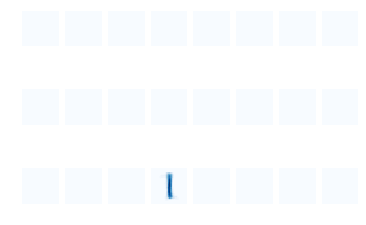

In [22]:
nr, nc = 3, 8
for i in range(nr*nc):
    plt.subplot(nr,nc,i+1)
    plt.imshow(Hebb[i].reshape(28,28), interpolation='nearest',cmap='Blues')
    plt.axis('off')

### .... and some of the latest ANTI-Hebbian updates 

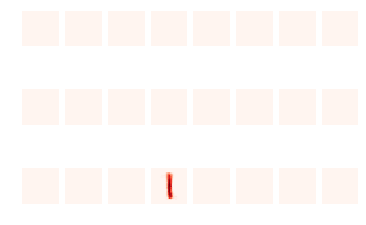

In [23]:
for i in range(nr*nc):
    plt.subplot(nr,nc,i+1)
    plt.imshow(AntiHebb[i].reshape(28,28), interpolation='nearest',cmap='Reds')
    plt.axis('off')

## features (ie. the current weights...)
I could draw the visible bias weights as an image here too....

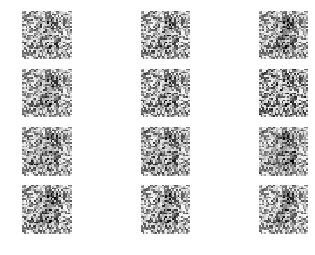

In [26]:
i=0
for r in range(4):
    for c in range(3):
        plt.subplot(4,3,i+1)
        plt.imshow(W[i].reshape(28,28), cmap='Greys', interpolation='nearest')
        plt.axis('off')
        i += 1

## dreams
Will they ever make sense?

So, presumably we should see them falling away from their initial state into the land of dreams as the model loses track of where it started from.

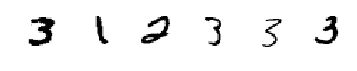

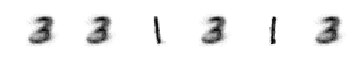

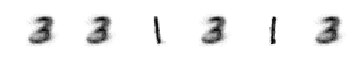

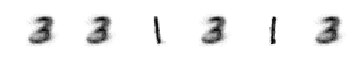

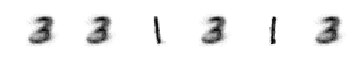

In [33]:
num_examples = 6
Vis_test = np.copy(vis_train_pats[rng.randint(0, num_pats, size=(6)), :])
i = 0
num_Gibbs = 0
for s in range(5):
    for t in range(num_Gibbs):
        # push visible pats into hidden 
        hid_prob1 = sigmoid(np.dot(V_test, W.T) + hid_bias)
        hid = 1*(hid_prob1 > rng.random(size=hid_prob1.shape))
        # push hidden pats into visible 
        vis_prob1 = sigmoid(np.dot(hid, W) + vis_bias)
        Vis_test = vis_prob1  # OR....  1*(v_prob1 > rng.random(size=v_prob1.shape))
    for n in range(num_examples):
        i += 1
        plt.subplot(5,num_examples,i)
        plt.imshow(Vis_test[n].reshape(28,28), cmap='Greys', interpolation='nearest')
        plt.axis('off')
        
    num_Gibbs = max(1, num_Gibbs * 2)  # wait longer before showing the next sample...
    plt.show()

huh?